In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder,StandardScaler,Normalizer
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample,shuffle
import lightgbm as lgb
from sklearn.impute import KNNImputer
import seaborn as sns
import plotly as py
import plotly.graph_objs as go


Upload Data & Explore

In [5]:
#importing the dataset
X_train = pd.read_csv('../data/01_raw/dengue_features_train.csv')
y_train = pd.read_csv('../data/01_raw/dengue_labels_train.csv')
X_test = pd.read_csv('../data/01_raw/dengue_features_test.csv')

In [6]:
#check the dataset
X_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [7]:
y_train.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [8]:
#check the shape of the dataset
X_train.shape,y_train.shape 

((1456, 24), (1456, 4))

In [9]:
#check for missing values
X_train.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

In [10]:
#check for missing values
y_train.isnull().sum()

city           0
year           0
weekofyear     0
total_cases    0
dtype: int64

In [11]:
#merge the two datasets
df = pd.merge(X_train,y_train,on=['city','year','weekofyear'])

#check the data
df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [12]:
#check the shape of the dataset
df.shape

(1456, 25)

In [13]:
#check for missing values
df.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

In [14]:
#check summary statistics
df.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,1456.000000,1456.000000,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000,...,1446.000000,1443.000000,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000,1456.000000
mean,2001.031593,26.503434,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356,...,82.161959,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360,24.675137
std,5.408314,15.019437,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810,...,7.153897,43.715537,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314,43.596000
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,...,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000,0.000000
25%,1997.000000,13.750000,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929,...,77.177143,9.800000,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000,5.000000
50%,2002.000000,26.500000,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714,...,80.301429,38.340000,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000,12.000000
75%,2005.000000,39.250000,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000,...,86.357857,70.235000,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000,28.000000
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,...,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000,461.000000


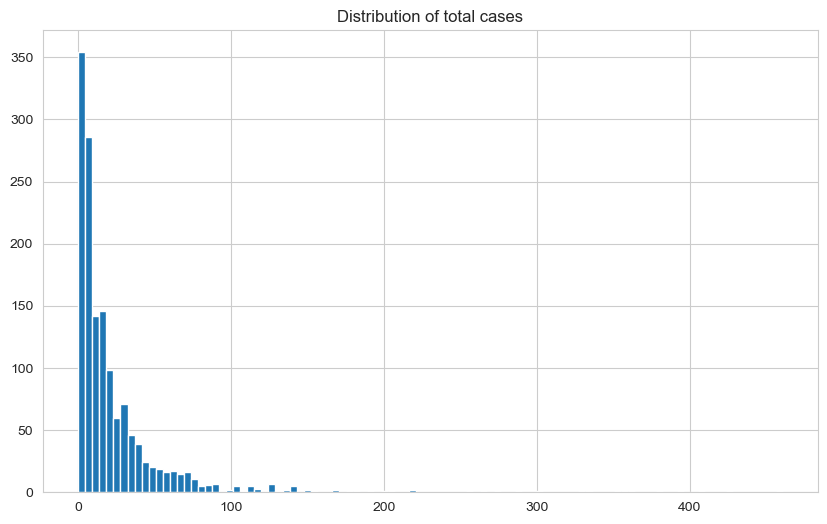

In [15]:
#plot the distribution of the target variable
plt.figure(figsize=(10,6))
plt.hist(df['total_cases'],bins=100)
plt.title('Distribution of total cases')
plt.show()

In [16]:
#creat table where we group total_cases by weekofyear
df.groupby('weekofyear')['total_cases'].sum()

weekofyear
1      678
2      728
3      677
4      652
5      620
6      530
7      487
8      478
9      453
10     387
11     313
12     279
13     302
14     239
15     232
16     239
17     212
18     241
19     236
20     254
21     237
22     296
23     281
24     305
25     344
26     404
27     403
28     464
29     511
30     633
31     720
32     898
33     906
34     920
35    1016
36    1102
37    1105
38    1109
39    1213
40    1403
41    1385
42    1345
43    1256
44    1325
45    1315
46    1164
47    1161
48    1107
49    1021
50     924
51     704
52     605
53     108
Name: total_cases, dtype: int64

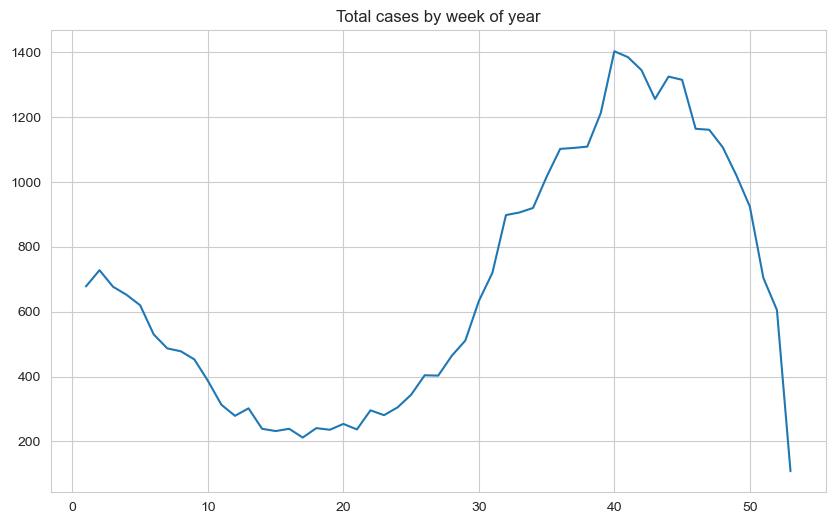

In [17]:
#plot the table we created
plt.figure(figsize=(10,6))
plt.plot(df.groupby('weekofyear')['total_cases'].sum())
plt.title('Total cases by week of year')
plt.show()

In [19]:
# show data of df
df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


2. One hot encoding for city variable

In [20]:
# do one hot encoding for city variable using category_encoders
encoder = ce.OneHotEncoder(cols='city')
df = encoder.fit_transform(df)
df.head()

,city_1,city_2,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1,0,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,1,0,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,1,0,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,1,0,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,1,0,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [21]:
#rename city_1 as sj and city_2 as iq
df.rename(columns={'city_1':'sj','city_2':'iq'},inplace=True)
df.head()

,sj,iq,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1,0,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,1,0,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,1,0,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,1,0,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,1,0,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [22]:
#drop the columns year and week_start_date
df.drop(['year','week_start_date'],axis=1,inplace=True)
df.head()

,sj,iq,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1,0,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,1,0,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,1,0,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,1,0,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,1,0,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


3. Cyclical encoding for weekofyear

In [23]:
#check the summary statistics
df.describe()

,sj,iq,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,1456.000000,1456.000000,1456.000000,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,...,1446.000000,1443.000000,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000,1456.000000
mean,0.642857,0.357143,26.503434,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,...,82.161959,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360,24.675137
std,0.479322,0.479322,15.019437,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,...,7.153897,43.715537,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314,43.596000
min,0.000000,0.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,...,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000,0.000000
25%,0.000000,0.000000,13.750000,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,...,77.177143,9.800000,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000,5.000000
50%,1.000000,0.000000,26.500000,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,...,80.301429,38.340000,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000,12.000000
75%,1.000000,1.000000,39.250000,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,...,86.357857,70.235000,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000,28.000000
max,1.000000,1.000000,53.000000,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,...,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000,461.000000


In [24]:
# cyclical encoding for weekofyear
df['weekofyear_sin'] = np.sin(2*np.pi*df['weekofyear']/52)
df['weekofyear_cos'] = np.cos(2*np.pi*df['weekofyear']/52)

#check the data
df.head()

,sj,iq,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,weekofyear_sin,weekofyear_cos
0,1,0,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4,0.822984,-0.568065
1,1,0,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5,0.748511,-0.663123
2,1,0,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4,0.663123,-0.748511
3,1,0,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3,0.568065,-0.822984
4,1,0,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6,0.464723,-0.885456


In [25]:
#check summary of the new variables
df[['weekofyear_sin','weekofyear_cos']].describe()

,weekofyear_sin,weekofyear_cos
count,1.456000e+03,1.456000e+03
mean,4.139309e-04,-2.503821e-05
std,7.073849e-01,7.073144e-01
min,-1.000000e+00,-1.000000e+00
25%,-6.844697e-01,-6.844697e-01
50%,1.608123e-16,-1.722546e-16
75%,6.844697e-01,6.844697e-01
max,1.000000e+00,1.000000e+00


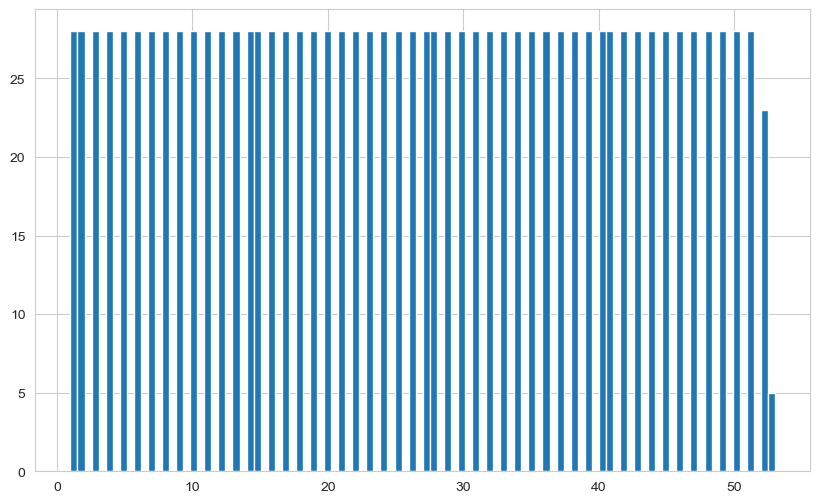

In [26]:
#check distribution of weekofyear
plt.figure(figsize=(10,6))
plt.hist(df['weekofyear'],bins=100)
plt.show()


In [27]:
#create a frequency table for weekofyear
df['weekofyear'].value_counts()


weekofyear
18    28
19    28
46    28
47    28
48    28
49    28
50    28
51    28
1     28
2     28
3     28
4     28
5     28
6     28
7     28
8     28
9     28
10    28
11    28
12    28
13    28
14    28
15    28
16    28
17    28
45    28
44    28
43    28
42    28
20    28
21    28
22    28
23    28
24    28
25    28
26    28
27    28
28    28
29    28
30    28
31    28
32    28
33    28
34    28
35    28
36    28
37    28
38    28
39    28
40    28
41    28
52    23
53     5
Name: count, dtype: int64

In [28]:
#drop the weekofyear column
df.drop('weekofyear',axis=1,inplace=True)

3. Fill missing values

In [29]:
#check for missing values
df.isnull().sum()

sj                                         0
iq                                         0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_min_temp_c                        14
station_precip_mm                         22
total_case

In [31]:
#fill missing values using KNN imputer
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)

df_filled = imputer.fit_transform(df)


In [32]:
#comepare summary stats of df and df_filled datasets
df_filled = pd.DataFrame(df_filled,columns=df.columns)
df_filled.describe()

,sj,iq,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,weekofyear_sin,weekofyear_cos
count,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,...,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1.456000e+03,1.456000e+03
mean,0.642857,0.357143,0.130988,0.128858,0.203515,0.202093,45.784635,298.701684,299.225671,295.248882,...,16.749139,4.903583,27.190128,8.102991,32.458338,22.102665,39.466387,24.675137,4.139309e-04,-2.503821e-05
std,0.479322,0.479322,0.135862,0.118622,0.073411,0.083380,43.625698,1.359097,1.258907,1.524896,...,1.539946,3.541506,1.280292,2.136518,1.957269,1.568748,47.287516,43.596000,7.073849e-01,7.073144e-01
min,0.000000,0.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,...,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000,0.000000,-1.000000e+00,-1.000000e+00
25%,0.000000,0.000000,0.037460,0.049375,0.155470,0.144621,9.825000,297.665000,298.262500,294.122143,...,15.561429,2.328571,26.316429,6.528571,31.100000,21.100000,8.700000,5.000000,-6.844697e-01,-6.844697e-01
50%,1.000000,0.000000,0.110717,0.117221,0.195736,0.188007,38.475000,298.643571,299.285714,295.642143,...,17.092143,2.857143,27.423167,7.342857,32.800000,22.200000,24.100000,12.000000,1.608123e-16,-1.722546e-16
75%,1.000000,1.000000,0.230127,0.212943,0.247461,0.246579,70.260000,299.829286,300.207143,296.460000,...,17.977500,7.632143,28.142857,9.700000,33.900000,23.300000,53.950000,28.000000,6.844697e-01,6.844697e-01
max,1.000000,1.000000,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,...,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000,461.000000,1.000000e+00,1.000000e+00


In [33]:
df.describe()

,sj,iq,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,weekofyear_sin,weekofyear_cos
count,1456.000000,1456.000000,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000,...,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000,1456.000000,1.456000e+03,1.456000e+03
mean,0.642857,0.357143,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356,...,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360,24.675137,4.139309e-04,-2.503821e-05
std,0.479322,0.479322,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810,...,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314,43.596000,7.073849e-01,7.073144e-01
min,0.000000,0.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,...,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000,0.000000,-1.000000e+00,-1.000000e+00
25%,0.000000,0.000000,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929,...,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000,5.000000,-6.844697e-01,-6.844697e-01
50%,1.000000,0.000000,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714,...,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000,12.000000,1.608123e-16,-1.722546e-16
75%,1.000000,1.000000,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000,...,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000,28.000000,6.844697e-01,6.844697e-01
max,1.000000,1.000000,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,...,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000,461.000000,1.000000e+00,1.000000e+00


In [34]:
#check for missing values
df_filled.isnull().sum()

sj                                       0
iq                                       0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
total_cases                              0
weekofyear_

In [35]:
#check the data
df_filled.head()

,sj,iq,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,weekofyear_sin,weekofyear_cos
0,1.0,0.0,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4.0,0.822984,-0.568065
1,1.0,0.0,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5.0,0.748511,-0.663123
2,1.0,0.0,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4.0,0.663123,-0.748511
3,1.0,0.0,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3.0,0.568065,-0.822984
4,1.0,0.0,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6.0,0.464723,-0.885456


4. Remove outliers

In [36]:
#remove outliers using z score method using the median
from scipy import stats
import numpy as np

# Calculate Z-scores 
df_filled['z_score']=stats.zscore(df_filled['total_cases'])

# Define outliers to be any points that are more than 3 standard deviations from the mean
df_filled_no_outliers = df_filled.loc[df_filled['z_score'].abs()<=3]


In [37]:
#check the shape of the dataset before and after removing outliers
df_filled.shape,df_filled_no_outliers.shape

((1456, 26), (1432, 26))

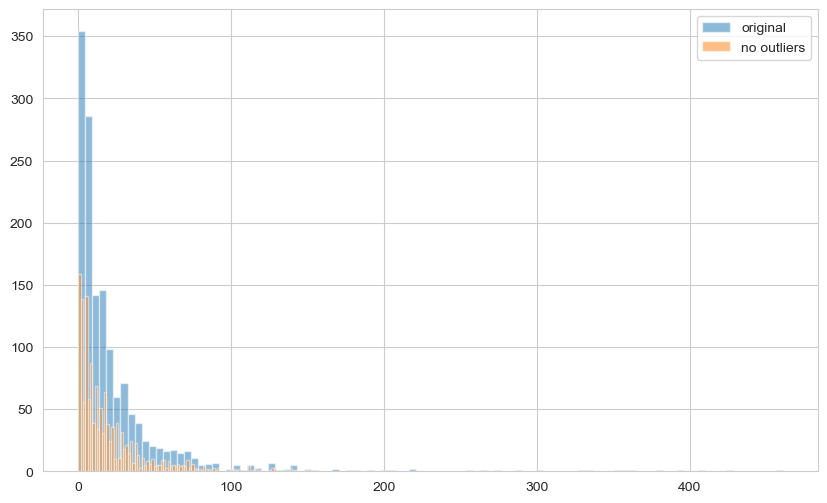

In [38]:
#plot the distribution of the target variable before and after removing outliers
plt.figure(figsize=(10,6))
plt.hist(df_filled['total_cases'],bins=100,alpha=0.5,label='original')
plt.hist(df_filled_no_outliers['total_cases'],bins=100,alpha=0.5,label='no outliers')
plt.legend()
plt.show()


In [39]:
#check the data
df_filled_no_outliers.head()

,sj,iq,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,weekofyear_sin,weekofyear_cos,z_score
0,1.0,0.0,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,2.628571,25.442857,6.900000,29.4,20.0,16.0,4.0,0.822984,-0.568065,-0.474407
1,1.0,0.0,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,2.371429,26.714286,6.371429,31.7,22.2,8.6,5.0,0.748511,-0.663123,-0.451461
2,1.0,0.0,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,2.300000,26.714286,6.485714,32.2,22.8,41.4,4.0,0.663123,-0.748511,-0.474407
3,1.0,0.0,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,2.428571,27.471429,6.771429,33.3,23.3,4.0,3.0,0.568065,-0.822984,-0.497353
4,1.0,0.0,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,3.014286,28.942857,9.371429,35.0,23.9,5.8,6.0,0.464723,-0.885456,-0.428515


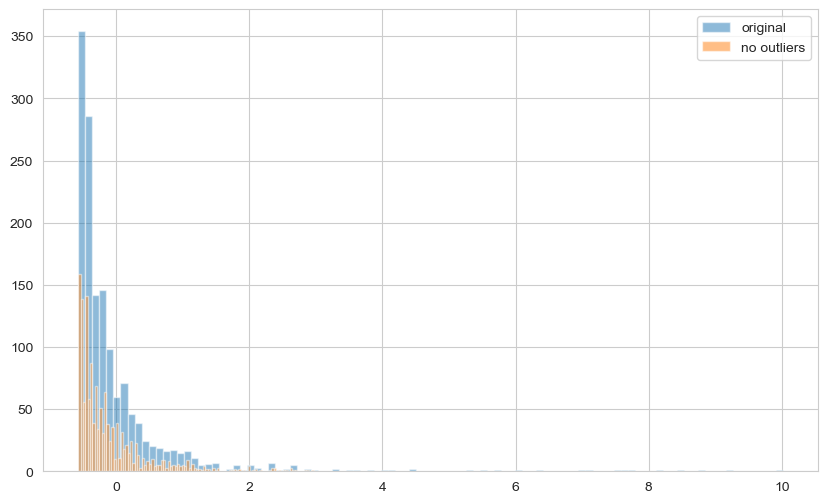

In [40]:
#compare z score before and aftr removing outliers
plt.figure(figsize=(10,6))
plt.hist(df_filled['z_score'],bins=100,alpha=0.5,label='original')
plt.hist(df_filled_no_outliers['z_score'],bins=100,alpha=0.5,label='no outliers')
plt.legend()
plt.show()

5. Scale the data

In [41]:
# check summary of weekofyear_sin and weekofyear_cos
df_filled_no_outliers[['weekofyear_sin','weekofyear_cos']].describe()

,weekofyear_sin,weekofyear_cos
count,1.432000e+03,1.432000e+03
mean,1.350436e-02,-8.087546e-04
std,7.054847e-01,7.090888e-01
min,-1.000000e+00,-1.000000e+00
25%,-6.631227e-01,-7.485107e-01
50%,6.432491e-16,-1.722546e-16
75%,7.485107e-01,7.485107e-01
max,1.000000e+00,1.000000e+00


In [42]:
#scale all the variables in the df_filled_no_outliers except for sj,iq,ndvi variables, and target variable dataset using the max absolute scaler
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()

df_filled_no_outliers_scaled = df_filled_no_outliers.copy()

df_filled_no_outliers_scaled[df_filled_no_outliers_scaled.columns[~df_filled_no_outliers_scaled.columns.isin(['sj','iq','ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw','total_cases','weekofyear_sin','weekofyear_cos'])]] = scaler.fit_transform(df_filled_no_outliers_scaled[df_filled_no_outliers_scaled.columns[~df_filled_no_outliers_scaled.columns.isin(['sj','iq','ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw','total_cases','weekofyear_sin','weekofyear_cos'])]])





In [43]:
#check the data
df_filled_no_outliers_scaled.head()

,sj,iq,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,weekofyear_sin,weekofyear_cos,z_score
0,1.0,0.0,0.122600,0.103725,0.198483,0.177617,0.031797,0.984688,0.982881,0.979776,...,0.163993,0.826067,0.436709,0.696682,0.781250,0.029450,4.0,0.822984,-0.568065,-0.159870
1,1.0,0.0,0.169900,0.142175,0.162357,0.155486,0.058423,0.986802,0.985192,0.984927,...,0.147950,0.867347,0.403255,0.751185,0.867187,0.015829,5.0,0.748511,-0.663123,-0.152137
2,1.0,0.0,0.032250,0.172967,0.157200,0.170843,0.088428,0.988688,0.986631,0.989895,...,0.143494,0.867347,0.410488,0.763033,0.890625,0.076201,4.0,0.663123,-0.748511,-0.159870
3,1.0,0.0,0.128633,0.245067,0.227557,0.235886,0.039324,0.989368,0.987786,0.989479,...,0.151515,0.891929,0.428571,0.789100,0.910156,0.007362,3.0,0.568065,-0.822984,-0.167602
4,1.0,0.0,0.196200,0.262200,0.251200,0.247340,0.019252,0.991127,0.989224,0.991193,...,0.188057,0.939703,0.593128,0.829384,0.933594,0.010676,6.0,0.464723,-0.885456,-0.144405


6. Split the data

In [44]:
# drop the z_score column
df_filled_no_outliers_scaled.drop('z_score',axis=1,inplace=True)


In [45]:
#spit into train and test
X_train = df_filled_no_outliers_scaled.drop('total_cases',axis=1)
y_train = df_filled_no_outliers_scaled['total_cases']

7. Train the model

In [46]:
#Train the model 
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=200,max_depth=7,min_samples_leaf=4,min_samples_split=5)

model.fit(X_train,y_train)


RandomForestRegressor(max_depth=7, min_samples_leaf=4, min_samples_split=5,
                      n_estimators=200)

8. Pre Process the test data

In [47]:
#check the data
X_test.head()


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [48]:
#check the shape of the dataset
X_test.shape

(416, 24)

In [49]:
#check for missing values
X_test.isnull().sum()

city                                      0
year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                  43
ndvi_nw                                  11
ndvi_se                                   1
ndvi_sw                                   1
precipitation_amt_mm                      2
reanalysis_air_temp_k                     2
reanalysis_avg_temp_k                     2
reanalysis_dew_point_temp_k               2
reanalysis_max_air_temp_k                 2
reanalysis_min_air_temp_k                 2
reanalysis_precip_amt_kg_per_m2           2
reanalysis_relative_humidity_percent      2
reanalysis_sat_precip_amt_mm              2
reanalysis_specific_humidity_g_per_kg     2
reanalysis_tdtr_k                         2
station_avg_temp_c                       12
station_diur_temp_rng_c                  12
station_max_temp_c                        3
station_min_temp_c              

In [50]:
# do one hot encoding for city variable using category_encoders
encoder = ce.OneHotEncoder(cols='city')
X_test = encoder.fit_transform(X_test)
X_test.head()

,city_1,city_2,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1,0,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,1,0,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,1,0,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,1,0,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,1,0,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [51]:
#rename city_1 as sj and city_2 as iq
X_test.rename(columns={'city_1':'sj','city_2':'iq'},inplace=True)
X_test.head()

,sj,iq,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1,0,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,1,0,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,1,0,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,1,0,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,1,0,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [52]:
#drop the columns year and week_start_date
X_test.drop(['year','week_start_date'],axis=1,inplace=True)
X_test.head()

,sj,iq,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1,0,18,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,1,0,19,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,1,0,20,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,1,0,21,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,1,0,22,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [53]:
#cycle encoding for weekofyear
X_test['weekofyear_sin'] = np.sin(2*np.pi*X_test['weekofyear']/52)
X_test['weekofyear_cos'] = np.cos(2*np.pi*X_test['weekofyear']/52)
X_test.head()

,sj,iq,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear_sin,weekofyear_cos
0,1,0,18,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,...,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,0.822984,-0.568065
1,1,0,19,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,...,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,0.748511,-0.663123
2,1,0,20,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,...,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,0.663123,-0.748511
3,1,0,21,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,...,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,0.568065,-0.822984
4,1,0,22,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,...,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1,0.464723,-0.885456


In [54]:
#drop the weekofyear column
X_test.drop('weekofyear',axis=1,inplace=True)


In [55]:
#check for missing values
X_test.isnull().sum()

sj                                        0
iq                                        0
ndvi_ne                                  43
ndvi_nw                                  11
ndvi_se                                   1
ndvi_sw                                   1
precipitation_amt_mm                      2
reanalysis_air_temp_k                     2
reanalysis_avg_temp_k                     2
reanalysis_dew_point_temp_k               2
reanalysis_max_air_temp_k                 2
reanalysis_min_air_temp_k                 2
reanalysis_precip_amt_kg_per_m2           2
reanalysis_relative_humidity_percent      2
reanalysis_sat_precip_amt_mm              2
reanalysis_specific_humidity_g_per_kg     2
reanalysis_tdtr_k                         2
station_avg_temp_c                       12
station_diur_temp_rng_c                  12
station_max_temp_c                        3
station_min_temp_c                        9
station_precip_mm                         5
weekofyear_sin                  

In [56]:
#fill missing values using KNN imputer without using the target variable

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)

X_test_filled = imputer.fit_transform(X_test)

In [57]:
#check for missing values
X_test_filled = pd.DataFrame(X_test_filled,columns=X_test.columns)
X_test_filled.isnull().sum()

sj                                       0
iq                                       0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
weekofyear_sin                           0
weekofyear_

In [59]:
#scale all the variables in the X_test_filled except for sj,iq,ndvi, weekofyear_sin andweekofyear_cos variables dataset using the max absolute scaler
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()

X_test_filled_scaled = X_test_filled.copy()

X_test_filled_scaled[X_test_filled_scaled.columns[~X_test_filled_scaled.columns.isin(['sj','iq','ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw','weekofyear_sin','weekofyear_cos'])]] = scaler.fit_transform(X_test_filled_scaled[X_test_filled_scaled.columns[~X_test_filled_scaled.columns.isin(['sj','iq','ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw','weekofyear_sin','weekofyear_cos'])]])


In [60]:
#check the data summary
X_test_filled_scaled.describe()


,sj,iq,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear_sin,weekofyear_cos
count,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,...,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,4.160000e+02,4.160000e+02
mean,0.625000,0.375000,0.127997,0.125359,0.207606,0.201615,0.225612,0.989668,0.986879,0.992006,...,0.225612,0.863380,0.352805,0.904046,0.533220,0.847059,0.837235,0.161661,2.897516e-04,-4.825219e-03
std,0.484706,0.484706,0.157286,0.139981,0.079031,0.091942,0.207585,0.004857,0.004301,0.005109,...,0.207585,0.079432,0.244380,0.040312,0.166284,0.050059,0.064363,0.163053,7.079829e-01,7.079170e-01
min,0.000000,0.000000,-0.463400,-0.211800,0.006200,-0.014671,0.000000,0.975553,0.973320,0.976575,...,0.000000,0.639697,0.102564,0.798018,0.274557,0.708333,0.531835,0.000000,-1.000000e+00,-1.000000e+00
25%,0.000000,0.000000,0.007675,0.016712,0.148677,0.134132,0.047966,0.986142,0.983475,0.988358,...,0.047966,0.805653,0.168393,0.876239,0.403444,0.809896,0.794007,0.042925,-6.844697e-01,-7.485107e-01
50%,1.000000,0.000000,0.116780,0.087475,0.203702,0.186386,0.183802,0.988758,0.986801,0.993363,...,0.183802,0.883811,0.201183,0.907079,0.453068,0.854167,0.831461,0.110849,-3.216245e-16,-1.836970e-16
75%,1.000000,1.000000,0.256050,0.241182,0.254807,0.253171,0.340838,0.994378,0.990746,0.996131,...,0.340838,0.927236,0.564103,0.934167,0.670826,0.882812,0.872659,0.226415,6.844697e-01,6.631227e-01
max,1.000000,1.000000,0.500400,0.649000,0.453043,0.529043,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00


9. Predict the target variable

In [61]:
#predict the target variable
y_pred = model.predict(X_test_filled_scaled)

10. Export prediction in the right format for submissions

In [62]:
#check the data
y_pred

array([ 9.16699996,  9.39192434, 10.21010551, 15.26859263, 12.74930945,
       13.1043722 , 11.10366391, 16.41987262, 34.82060064, 38.01131629,
       18.157035  , 27.94105881, 32.78249508, 38.77428412, 37.35343365,
       63.50151441, 35.05506642, 56.39450992, 68.40265899, 48.58353082,
       45.97542061, 43.16261948, 46.99806475, 42.64523428, 47.00707778,
       45.20306999, 49.36375558, 41.70018473, 42.62392913, 41.30242387,
       38.98083242, 44.74183756, 38.6959134 , 45.66179454, 27.73598688,
       52.35492418, 30.08061319, 47.92961006, 36.31419449, 46.69513974,
       21.55617943, 22.92399489, 20.57007128, 22.113816  , 15.89757903,
       13.61239944, 10.54497778,  8.88259782, 13.90370581, 11.24570423,
       10.94026514,  9.45952256, 10.45909904, 10.60434556, 13.27913218,
       13.0150629 , 31.07654256, 11.47612988, 15.98780544, 16.5048684 ,
       15.07041222, 32.2534371 , 43.21066598, 35.0189033 , 40.3599535 ,
       42.47702694, 34.8374799 , 57.2625022 , 36.97586746, 48.77

In [65]:
#save the y_pred as a csv file. please include the city, year, and weekofyear columns from the original X-test dataset
X_test_v2 = pd.read_csv('../data/01_raw/dengue_features_test.csv')

X_test_v2['total_cases'] = y_pred

#change the total_cases into integer
X_test_v2.total_cases = X_test_v2.total_cases.astype(int)


#keep only city, year, weekofyear, and total_cases columns
X_test_v2 = X_test_v2[['city','year','weekofyear','total_cases']]

#check the data
X_test_v2.head()


,city,year,weekofyear,total_cases
0,sj,2008,18,9
1,sj,2008,19,9
2,sj,2008,20,10
3,sj,2008,21,15
4,sj,2008,22,12


In [67]:
#export the data to csv in ../data/08_reporting folder
X_test_v2[['city','year','weekofyear','total_cases']].to_csv('../data/08_reporting/submission.csv',index=False)

11. Other background work not used in v2 workflow / ignore

In [73]:
#we want to test which of the machine learning alogrithim will work best for this dataset. let us write code that we can try out different model to see the performance of the best one for this dataset      
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

models = [RandomForestRegressor(),LinearRegression(),SVR()]

for model in models:
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(f'{model} MSE: {mean_squared_error(y_test,y_pred)}')

RandomForestRegressor() MSE: 406.71694216027873
LinearRegression() MSE: 466.33090156794424
SVR() MSE: 515.257572877534


In [74]:
#let us now try to tune the random forest regressor model. let us try to run different hyprparameters to see which one will work best for this dataset
from sklearn.model_selection import GridSearchCV

#use more detailed parameters so for max_depth let's try between 3 and 10 for example. same approahc for the other parameters

param_grid = {
    'n_estimators':[100,200,300],
    'max_depth':[3,5,7,10],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4]
}

grid_search = GridSearchCV(RandomForestRegressor(),param_grid,cv=5,scoring='neg_mean_squared_error')

grid_search.fit(X_train,y_train)

grid_search.best_params_

    



{'max_depth': 7,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 200}

In [79]:
#train the model with the best parameters
model = RandomForestRegressor(n_estimators=200,max_depth=7,min_samples_leaf=4,min_samples_split=5)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

mean_squared_error(y_test,y_pred)


401.0418081380629

In [ ]:
#let us train th model with the entire datast without splitting between train and test
model = RandomForestRegressor(n_estimators=200,max_depth=7,min_samples_leaf=4,min_samples_split=5)

model.fit(X,y)


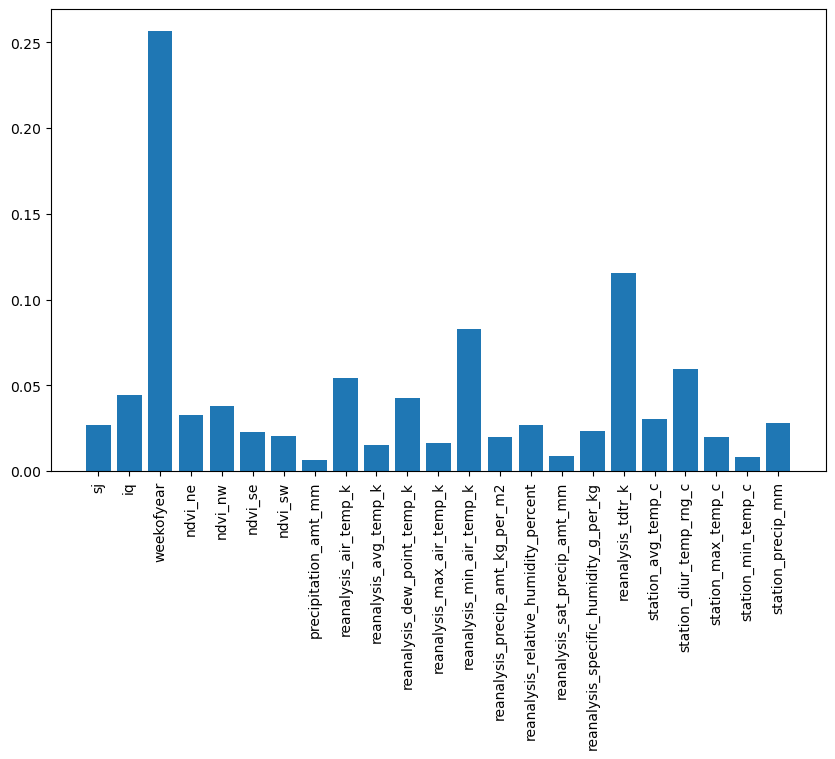

In [80]:
#plot the feature importance
plt.figure(figsize=(10,6))
plt.bar(X_train.columns,model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [81]:
#calculcate the MASE of the model
def MASE(training_series, testing_series, prediction_series):
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d



In [82]:
# let us train the model now with the entire data set X and y
model.fit(X,y)

y_pred_all = model.predict(X)

mean_squared_error(y,y_pred_all)


218.91106876582575

In [109]:
#let us load the dengue_features_test.csv and use our model to predict the target variable
X_test = pd.read_csv('dengue_features_test.csv')


In [110]:
#check the data
X_test.head()


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [111]:
#check the shape of the dataset
X_test.shape

(416, 24)

In [112]:
#check the data
X_test.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [113]:
#do one hot encoding for city variable using category_encoders
encoder = ce.OneHotEncoder(cols='city')
X_test = encoder.fit_transform(X_test)
X_test.head()


,city_1,city_2,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1,0,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,1,0,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,1,0,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,1,0,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,1,0,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [114]:
#rename city_1 as sj and city_2 as iq
X_test.rename(columns={'city_1':'sj','city_2':'iq'},inplace=True)

In [115]:
#drop the columns year and week_start_date
X_test.drop(['year','week_start_date'],axis=1,inplace=True)

In [116]:
#check the data
X_test.head()

,sj,iq,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1,0,18,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,1,0,19,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,1,0,20,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,1,0,21,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,1,0,22,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [117]:
#check for missing values
X_test.isnull().sum()

sj                                        0
iq                                        0
weekofyear                                0
ndvi_ne                                  43
ndvi_nw                                  11
ndvi_se                                   1
ndvi_sw                                   1
precipitation_amt_mm                      2
reanalysis_air_temp_k                     2
reanalysis_avg_temp_k                     2
reanalysis_dew_point_temp_k               2
reanalysis_max_air_temp_k                 2
reanalysis_min_air_temp_k                 2
reanalysis_precip_amt_kg_per_m2           2
reanalysis_relative_humidity_percent      2
reanalysis_sat_precip_amt_mm              2
reanalysis_specific_humidity_g_per_kg     2
reanalysis_tdtr_k                         2
station_avg_temp_c                       12
station_diur_temp_rng_c                  12
station_max_temp_c                        3
station_min_temp_c                        9
station_precip_mm               

In [118]:
#fill missing values using KNN imputer without using the target variable

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)

X_test_filled = imputer.fit_transform(X_test)


In [119]:
#check for missing values
X_test_filled = pd.DataFrame(X_test_filled,columns=X_test.columns)

In [106]:
#check for missing values
X_test_filled.isnull().sum()

sj                                       0
iq                                       0
weekofyear                               0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
dtype: int6

In [120]:
#scale all the variables in the X_test_filled except for sj,iq,ndvi variables dataset using the max absolute scaler
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()

X_test_filled_scaled = X_test_filled.copy()

X_test_filled_scaled[X_test_filled_scaled.columns[~X_test_filled_scaled.columns.isin(['sj','iq','ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw'])]] = scaler.fit_transform(X_test_filled_scaled[X_test_filled_scaled.columns[~X_test_filled_scaled.columns.isin(['sj','iq','ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw'])]])


In [121]:
#check the data
X_test_filled_scaled.head()

,sj,iq,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1.0,0.0,0.339623,-0.01890,-0.018900,0.102729,0.091200,0.464155,0.988597,0.984246,...,0.084174,0.804033,0.464155,0.812231,0.215976,0.876357,0.479263,0.867188,0.812734,0.354717
1,1.0,0.0,0.358491,-0.01800,-0.012400,0.082043,0.072314,0.074170,0.988541,0.984270,...,0.072429,0.798405,0.074170,0.805744,0.177515,0.861255,0.377395,0.781250,0.831461,0.161792
2,1.0,0.0,0.377358,-0.00150,-0.011829,0.151083,0.091529,0.021613,0.991786,0.986907,...,0.013670,0.798813,0.021613,0.850791,0.305720,0.922605,0.528741,0.854167,0.853933,0.014151
3,1.0,0.0,0.396226,-0.01876,-0.019867,0.124329,0.125686,0.000000,0.992562,0.988132,...,0.007299,0.745189,0.000000,0.804942,0.299803,0.926852,0.425903,0.867188,0.913858,0.001415
4,1.0,0.0,0.415094,0.05680,0.039833,0.062267,0.075914,0.004488,0.992860,0.987943,...,0.014466,0.756094,0.004488,0.823384,0.244576,0.912223,0.481203,0.867188,0.872659,0.396698


In [122]:
#predict the target variable
y_pred = model.predict(X_test_filled_scaled)

In [123]:
#check the data
y_pred

array([ 9.86352144, 11.22212725, 10.07174299, 19.08526174, 13.50323918,
       14.80943859, 11.29135113, 15.62310648, 34.28988099, 41.45365892,
       17.55785682, 28.76271165, 38.88978433, 39.82098563, 39.09009932,
       62.64337499, 36.16660716, 53.2234947 , 62.8248851 , 45.69039172,
       41.71327874, 41.61944957, 46.33483336, 41.27591488, 46.16946582,
       42.17987468, 56.28878691, 46.1485818 , 46.11125063, 45.04753187,
       41.59232645, 54.59133897, 43.73718038, 43.55456586, 30.35679513,
       46.23437604, 28.55253873, 42.30389594, 40.16373085, 44.41255677,
       24.44969482, 23.4747629 , 18.40084412, 18.2416168 , 15.63997252,
       11.61039627, 10.1821778 ,  8.44558473, 14.6726126 , 11.52256118,
       10.56201144, 10.16764638, 11.40364373, 13.31041575, 13.55041389,
       13.55368773, 33.74059852, 11.77277765, 14.96884993, 16.35453063,
       12.74825381, 32.2613376 , 37.78517218, 38.84437552, 42.327739  ,
       38.18590321, 38.53222695, 52.60509805, 36.31339563, 48.32

In [127]:
#save the y_pred as a csv file. please include the city, year, and weekofyear columns from the original X-test dataset
X_test_v2 = pd.read_csv('dengue_features_test.csv')

X_test_v2['total_cases'] = y_pred

X_test_v2[['city','year','weekofyear','total_cases']].to_csv('submission.csv',index=False)


In [128]:
X_test_v2.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,9.863521
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,11.222127
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,10.071743
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,19.085262
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1,13.503239


In [129]:
#keep only the city, year, weekofyear, and total_cases columns
X_test_v2 = X_test_v2[['city','year','weekofyear','total_cases']]

In [130]:
X_test_v2.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,9.863521
1,sj,2008,19,11.222127
2,sj,2008,20,10.071743
3,sj,2008,21,19.085262
4,sj,2008,22,13.503239


In [133]:
#change total_cases into integer
X_test_v2.total_cases = X_test_v2.total_cases.astype(int)

In [136]:
#save the data
X_test_v2.to_csv('submissionv2.csv',index=False)

In [138]:
#save data to src folder
X_test_v2.to_csv('submissionv2.csv',index=False)